<a href="https://colab.research.google.com/github/Ortsang/SNFVBP-analysis/blob/main/SNFVBP_dataclean_oneyear.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from google.colab import drive
import tempfile
from zipfile import ZipFile
drive.mount('/content/drive')
import glob, os
import openpyxl

Mounted at /content/drive


In [2]:
%cd /content/drive/My\ Drive/Res/SNFVBP/data/nursinghomecompare

/content/drive/My Drive/Res/SNFVBP/data/nursinghomecompare


### 2024 05 Data

In [3]:
%cd nursing_homes_including_rehab_services_2024/*nursing_homes_including_rehab_services_05_2024
%ls

/content/drive/My Drive/Res/SNFVBP/data/nursinghomecompare/nursing_homes_including_rehab_services_2024/*nursing_homes_including_rehab_services_05_2024
FY_2024_SNF_VBP_Aggregate_Performance.csv
FY_2024_SNF_VBP_Facility_Performance.csv
NH_CitationDescriptions_May2024.csv
NH_CovidVaxAverages_20240512.csv
NH_CovidVaxProvider_20240512.csv
NH_DataCollectionIntervals_May2024.csv
NH_Data_Dictionary.pdf
NH_FireSafetyCitations_May2024.csv
NH_HealthCitations_May2024.csv
NH_HlthInspecCutpointsState_May2024.csv
NH_Ownership_May2024.csv
NH_Penalties_May2024.csv
NH_ProviderInfo_May2024.csv
NH_QualityMsr_Claims_May2024.csv
NH_QualityMsr_MDS_May2024.csv
NH_StateUSAverages_May2024.csv
NH_SurveyDates_May2024.csv
NH_SurveySummary_May2024.csv
readme.txt
Skilled_Nursing_Facility_Quality_Reporting_Program_National_Data_May2024.csv
Skilled_Nursing_Facility_Quality_Reporting_Program_Provider_Data_May2024.csv
Swing_Bed_SNF_data_May2024.csv


In [11]:
df_clm_0405  = pd.DataFrame() #MSR = MSR Claims
df_info_0405 = pd.DataFrame() #Provider information

current_directory = os.getcwd()
# Get a list of all files and directories in the current directory
files = os.listdir(current_directory)

k = [s for s in files if "Provider" in s and "Info" in s][0]
df_info_0405 = pd.read_csv(k,encoding='ISO-8859-1',low_memory=False).set_index('CMS Certification Number (CCN)')

In [15]:
k = [s for s in files if "Claims" in s][0]
df_clm_0405 = pd.read_csv(k,encoding='ISO-8859-1',low_memory=False)
#df_clm_0405['CMS Certification Number (CCN)'] = pd.to_numeric(df_clm_0405['CMS Certification Number (CCN)'], errors='coerce')
#df_clm_0405['CMS Certification Number (CCN)'] = df_clm_0405['CMS Certification Number (CCN)'].map(lambda x: '{:.0f}'.format(x) if not pd.isnull(x) else str(x))


df_clm_0405_long = df_clm_0405[['CMS Certification Number (CCN)','Measure Code',
                                             'Adjusted Score','Observed Score','Expected Score']].drop_duplicates(subset=['CMS Certification Number (CCN)',
                                                                                                                          'Measure Code'], keep='first')
df_clm_0405_wide = df_clm_0405_long.pivot(index='CMS Certification Number (CCN)',
                                 columns='Measure Code', values=['Adjusted Score','Observed Score','Expected Score'])

In [24]:
df_clm_0405_wide

Adjusted Score                                 \
Measure Code                              521        522       551       552   
CMS Certification Number (CCN)                                                 
015009                              19.432546   8.434253  1.666085  0.500761   
015010                              15.141017  14.818883  2.033333  1.322111   
015012                              22.162459  23.231519  2.384314  1.888500   
015014                              14.019648   7.925566  1.588928  0.633824   
015015                              22.538068  12.364821  2.045821  1.083820   
...                                       ...        ...       ...       ...   
745021                              34.036239  25.837596  1.672981  2.022291   
745022                                    NaN        NaN  1.358966  0.439739   
745038                              29.534040  22.819970       NaN       NaN   
745039                                    NaN        NaN       NaN       NaN   
745040                                    NaN        NaN       NaN       NaN   

                               Observed Score                                 \
Measure Code                              521        522       551       552   
CMS Certification Number (CCN)                                                 
015009                              19.672131   8.196721  1.422602  0.622388   
015010                              13.043478  13.043478  1.314708  1.396878   
015012                              17.283951  20.987654  1.683704  2.645821   
015014                              14.285714   9.523810  1.316656  0.740619   
015015                              18.518519  11.111111  1.289717  1.289717   
...                                       ...        ...       ...       ...   
745021                              35.000000  25.000000  4.699928  5.061461   
745022                                    NaN        NaN  0.929501  0.572001   
745038                              30.000000  20.000000       NaN       NaN   
745039                                    NaN        NaN       NaN       NaN   
745040                                    NaN        NaN       NaN       NaN   

                               Expected Score                                 
Measure Code                              521        522       551       552  
CMS Certification Number (CCN)                                                
015009                              23.328992  10.770157  1.464588  2.001603  
015010                              19.852383   9.754532  1.109047  1.701523  
015012                              17.972121  10.011860  1.211244  2.256268  
015014                              23.482218  13.317077  1.421338  1.881799  
015015                              18.934935   9.958596  1.081325  1.916393  
...                                       ...        ...       ...       ...  
745021                              23.697403  10.723002  4.818696  4.030689  
745022                                    NaN        NaN  1.173196  2.094831  
745038                              23.408450   9.712777       NaN       NaN  
745039                                    NaN        NaN       NaN       NaN  
745040                                    NaN        NaN       NaN       NaN  

[14858 rows x 12 columns]

In [18]:
df_snfvbp_0405 = pd.read_csv("FY_2024_SNF_VBP_Facility_Performance.csv",encoding='ISO-8859-1',low_memory=False)
df_snfvbp_0405['CMS Certification Number (CCN)'] = df_snfvbp_0405['CMS Certification Number (CCN)'].astype(str).str.zfill(6)
df_snfvbp_0405 = df_snfvbp_0405.set_index('CMS Certification Number (CCN)')

In [27]:
df_0405 = pd.concat([df_info_0405,df_clm_0405_wide,df_snfvbp_0405],axis=1)
columns_to_drop = [col for col in df_0405.columns if any(string in col for string in ['note','Footnote'])]
df_0405 = df_0405.drop(columns=columns_to_drop)

In [30]:
df_0405[df_0405.index=="555811"]

,Provider Name,Provider Address,City/Town,State,ZIP Code,Telephone Number,Provider SSA County Code,County/Parish,Ownership Type,Number of Certified Beds,...,Provider Address,City/Town,State,ZIP Code,Baseline Period: FY 2019 Risk-Standardized Readmission Rate,Performance Period: FY 2022 Risk-Standardized Readmission Rate,Achievement Score,Improvement Score,Performance Score,Incentive Payment Multiplier
CMS Certification Number (CCN),,,,,,,,,,,,,,,,,,,,,
555811,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3 PURSUIT,ALISO VIEJO,CA,92656.0,0.21816,0.19412,36.50718,44.57723,44.57723,0.993946


In [52]:
columns_select = [col for col in df_0405.columns if any(string in col for string in ['Adjusted Score','Performance Score','Achievement Score',
                                                                                     'Improvement Score','Incentive Payment Multiplier'])]
df_0405_graph = df_0405[columns_select]
df_0405_graph = df_0405_graph[df_0405_graph[('Performance Score')].notna()&df_0405_graph[('Performance Score')]!=0]
df_0405_graph.head(10)

,"(Adjusted Score, 521)","(Adjusted Score, 522)","(Adjusted Score, 551)","(Adjusted Score, 552)",Achievement Score,Improvement Score,Performance Score,Incentive Payment Multiplier
CMS Certification Number (CCN),,,,,,,,
015009,19.432546,8.434253,1.666085,0.500761,62.91866,0.00000,62.91866,1.009757
015012,22.162459,23.231519,2.384314,1.888500,15.71770,33.83352,33.83352,0.986284
015016,27.468720,18.104440,2.625364,1.366477,73.51675,71.93296,73.51675,1.014635
015019,7.030967,3.488946,0.511543,0.430685,74.47368,0.00000,74.47368,1.014912
015027,40.806981,6.735978,4.082385,1.305702,0.00000,5.31579,5.31579,0.980430
015031,21.506069,9.661573,0.675674,0.728762,43.15789,0.00000,43.15789,0.992720
015032,22.379494,9.302878,1.955540,1.278448,41.72249,61.43051,61.43051,1.008762
015034,13.857182,16.561661,2.097536,1.125824,30.71770,42.03331,42.03331,0.991787
015035,17.097066,22.005726,1.913886,2.123261,46.00478,14.40181,46.00478,0.995227


In [55]:
# Create quartiles for column 'B'
df_0405_graph['PfmSc_quartile'] = pd.qcut(df_0405_graph['Performance Score'], 4,
                                          labels=False, duplicates='drop')
df_0405_graph.head(3)

,"(Adjusted Score, 521)","(Adjusted Score, 522)","(Adjusted Score, 551)","(Adjusted Score, 552)",Achievement Score,Improvement Score,Performance Score,Incentive Payment Multiplier,PfmSc_quartile
CMS Certification Number (CCN),,,,,,,,,
015009,19.432546,8.434253,1.666085,0.500761,62.91866,0.00000,62.91866,1.009757,2
015012,22.162459,23.231519,2.384314,1.888500,15.71770,33.83352,33.83352,0.986284,1
015016,27.468720,18.104440,2.625364,1.366477,73.51675,71.93296,73.51675,1.014635,3


In [56]:
df_0405_graph.columns

Index([       ('Adjusted Score', 521),        ('Adjusted Score', 522),
              ('Adjusted Score', 551),        ('Adjusted Score', 552),
                  'Achievement Score',            'Improvement Score',
                  'Performance Score', 'Incentive Payment Multiplier',
                     'PfmSc_quartile'],
      dtype='object')

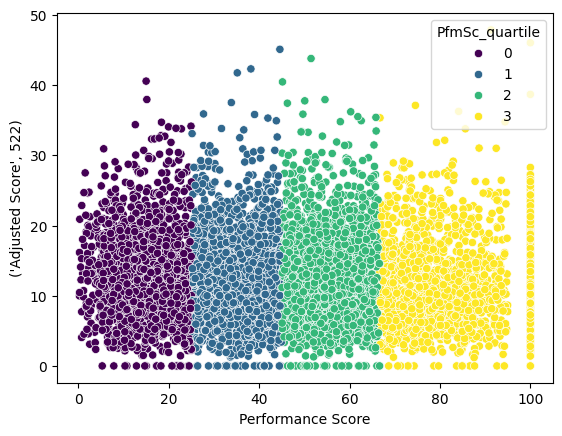

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create the dot plot using seaborn
sns.scatterplot(x='Performance Score', y=('Adjusted Score',522), hue='PfmSc_quartile', data=df_0405_graph, palette='viridis')
plt.show()

In [62]:
table = pd.pivot_table(df_0405_graph, values=[('Adjusted Score', 521), ('Adjusted Score', 522),
                                              ('Adjusted Score', 551),  ('Adjusted Score', 552)],
                       index=['PfmSc_quartile'],
                       aggfunc={"mean"})
table

Adjusted Score                               
                          521        522       551       552
                         mean       mean      mean      mean
PfmSc_quartile                                              
0                   23.913672  12.645714  2.029289  1.236785
1                   23.134210  12.602412  1.942587  1.190752
2                   22.228479  12.680277  1.808999  1.200303
3                   20.354604  11.779328  1.612352  1.014184

## Data 2020-2023

In [3]:
df_archive_clm  = pd.DataFrame() #MSR = MSR Claims
df_archive_mds = pd.DataFrame() #MDS = MSR MDS
n = 1
# Define a list of years for which you have files
years = [2020,2021,2022,2023]
# Loop through the years
for year in years:
  directory = f'/content/drive/My Drive/Res/SNFVBP/data/nursinghomecompare/nursing_homes_including_rehab_services_{year}'
  os.chdir(directory)
  n = 1

  for file in glob.glob("*.zip"):
      archive = ZipFile(file, 'r')
      # Provider info
      k = [s for s in archive.namelist() if "Provider" in s and "Info" in s][0]
      data = pd.read_csv(archive.open(k),encoding='ISO-8859-1',low_memory=False)
      data = data.rename(columns={"Federal Provider Number": "PROVNUM",
                            'Provider Name':'PROVNAME',
                            'Provider City':'CITY',
                            'Provider State':'STATE',
                            'Provider Zip Code':'ZIP',
                            'Ownership Type':'OWNERSHIP',
                            'Number of Certified Beds':'BEDCERT',
                            'Average Number of Residents per Day':'RESTOT',
                            'Provider Resides in Hospital':'INHOSP',
                            'Provider Changed Ownership in Last 12 Months':'CHOW_LAST_12MOS',
                            'Overall Rating':'OVERALL_RATING',
                            'Number of Fines':'FINE_CNT',
                            'Total Amount of Fines in Dollars':'FINE_TOT'})
      data = data.rename(columns={"CMS Certification Number (CCN)": "PROVNUM",
                            'Provider Name':'PROVNAME',
                            'City/Town':'CITY',
                            'State':'STATE',
                            'ZIP Code':'ZIP',
                            'Ownership Type':'OWNERSHIP',
                            'Number of Certified Beds':'BEDCERT',
                            'Average Number of Residents per Day':'RESTOT',
                            'Provider Resides in Hospital':'INHOSP',
                            'Provider Changed Ownership in Last 12 Months':'CHOW_LAST_12MOS',
                            'Overall Rating':'OVERALL_RATING',
                            'Number of Fines':'FINE_CNT',
                            'Total Amount of Fines in Dollars':'FINE_TOT'})
      data.columns = data.columns.str.upper()
      df_provider_month = data.loc[:,['PROVNUM', 'PROVNAME', 'CITY',
            'STATE', 'ZIP', 'OWNERSHIP','BEDCERT', 'RESTOT',
            'INHOSP','CHOW_LAST_12MOS', 'OVERALL_RATING',
            'FINE_CNT', 'FINE_TOT']]

      # Claims data
      k = [s for s in archive.namelist() if "Claims" in s][0]
      data = pd.read_csv(archive.open(k),encoding='ISO-8859-1',low_memory=False)

      ## unify the column names
      for column_name in data.columns:
        if "Measure Code" in column_name:
          data = data.rename(columns={"Federal Provider Number": "PROVNUM",
                                              "Measure Period": "MEASURE_PERIOD",
                                              "Adjusted Score":"SCORE_ADJUSTED",
                                              "Measure Code":"MSR_CD",
                                      'Provider Zip Code':'ZIP'})
        elif '(CCN)' in column_name:
          data = data.rename(columns={"CMS Certification Number (CCN)": "PROVNUM",
                                      'ZIP Code':'ZIP'})
      #print(k,data.columns)
      #df_archive_month = data.pivot(index=['PROVNUM','MEASURE_PERIOD'], columns='MSR_CD')[[('SCORE_ADJUSTED', 521),('SCORE_ADJUSTED', 522)]]
      df_archive_month = data.loc[:,['PROVNUM','MEASURE_PERIOD','SCORE_ADJUSTED','MSR_CD']]
      df_archive_month["FILEMONTH"] = n
      df_archive_month['FILEYEAR'] = year
      df_archive_month = df_archive_month.merge(df_provider_month, on='PROVNUM', how='left')
      df_archive_clm = pd.concat([df_archive_clm,df_archive_month])

      # MDS data
      k = [s for s in archive.namelist() if "MDS" in s][0]
      data = pd.read_csv(archive.open(k),encoding='ISO-8859-1',low_memory=False)
      # unify the column names
      for column_name in data.columns:
        if "Measure Code" in column_name:
          data = data.rename(columns={"Federal Provider Number": "PROVNUM",
                                              "Measure Period": "MEASURE_PERIOD",
                                              "Adjusted Score":"SCORE_ADJUSTED",
                                              "Measure Code":"MSR_CD",
                                      "Four Quarter Average Score":"MEASURE_SCORE_4QTR_AVG"})
        elif '(CCN)' in column_name:
          data = data.rename(columns={"CMS Certification Number (CCN)": "PROVNUM",
                                      "Measure Code":"MSR_CD",
                              "Four Quarter Average Score":"MEASURE_SCORE_4QTR_AVG"})

      if 'Q1_QUARTER' in data.columns:
        df_archive_month = data.loc[:,['PROVNUM','Q1_QUARTER','MEASURE_SCORE_4QTR_AVG','MSR_CD']]
        df_archive_month = df_archive_month.rename(columns={"Q1_QUARTER": "MEASURE_PERIOD"})
      else:
        df_archive_month = data.loc[:,['PROVNUM','MEASURE_PERIOD','MEASURE_SCORE_4QTR_AVG','MSR_CD']]
      df_archive_month["FILEMONTH"] = n
      df_archive_month['FILEYEAR'] = year
      df_archive_month = df_archive_month.merge(df_provider_month, on='PROVNUM', how='left')
      df_archive_mds = pd.concat([df_archive_mds,df_archive_month])
      n += 1

df_archive_mds['MEASURE_PERIOD'] = df_archive_mds['MEASURE_PERIOD'].str.split('-').str[0]
df_archive_mds['MEASURE_YEAR'] = df_archive_mds['MEASURE_PERIOD'].str.extract(r'(\d{4})')
df_archive_clm['MEASURE_PERIOD'] = df_archive_clm['MEASURE_PERIOD'].str.split('-').str[0]
df = pd.DataFrame()
df[['Year', 'Quarter']] = df_archive_clm['MEASURE_PERIOD'].str.extract(r'(\d{4})(\d{4})')
quarter_mapping = {'0101': 'Q1', '0401': 'Q2', '0701': 'Q3', '1001': 'Q4'}
df['Quarter'] = df['Quarter'].map(quarter_mapping)
df['FQ'] = df['Year'] + df['Quarter']
df['FQ'].fillna(df_archive_clm['MEASURE_PERIOD'], inplace=True)
df_archive_clm['MEASURE_PERIOD'] = df['FQ']
df_archive_clm['MEASURE_YEAR'] = df['Year']

<ipython-input-3-9c4e31242007>:107: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['FQ'].fillna(df_archive_clm['MEASURE_PERIOD'], inplace=True)


In [4]:
# every quarter the measuring statistics are the same
df_archive_clm = df_archive_clm.drop_duplicates(subset=['PROVNUM', 'MEASURE_PERIOD', 'MSR_CD'], keep='first')
df_archive_mds = df_archive_mds.drop_duplicates(subset=['PROVNUM', 'MEASURE_PERIOD', 'MSR_CD'], keep='first')

In [5]:
df_archive_clm.head(10)

,PROVNUM,MEASURE_PERIOD,SCORE_ADJUSTED,MSR_CD,FILEMONTH,FILEYEAR,PROVNAME,CITY,STATE,ZIP,OWNERSHIP,BEDCERT,RESTOT,INHOSP,CHOW_LAST_12MOS,OVERALL_RATING,FINE_CNT,FINE_TOT,MEASURE_YEAR
0,015009,2018Q3,16.105438,521,1,2020,"BURNS NURSING HOME, INC.",RUSSELLVILLE,AL,35653,For profit - Corporation,57,52.4,N,N,5.0,0,0.0,2018
1,015009,2018Q3,4.527000,522,1,2020,"BURNS NURSING HOME, INC.",RUSSELLVILLE,AL,35653,For profit - Corporation,57,52.4,N,N,5.0,0,0.0,2018
2,015009,2018Q3,2.268995,551,1,2020,"BURNS NURSING HOME, INC.",RUSSELLVILLE,AL,35653,For profit - Corporation,57,52.4,N,N,5.0,0,0.0,2018
3,015009,2018Q3,0.630341,552,1,2020,"BURNS NURSING HOME, INC.",RUSSELLVILLE,AL,35653,For profit - Corporation,57,52.4,N,N,5.0,0,0.0,2018
4,015010,2018Q3,21.017572,521,1,2020,COOSA VALLEY HEALTHCARE CENTER,SYLACAUGA,AL,35150,For profit - Corporation,85,75.0,N,N,4.0,0,0.0,2018
5,015010,2018Q3,8.881038,522,1,2020,COOSA VALLEY HEALTHCARE CENTER,SYLACAUGA,AL,35150,For profit - Corporation,85,75.0,N,N,4.0,0,0.0,2018
6,015010,2018Q3,1.991611,551,1,2020,COOSA VALLEY HEALTHCARE CENTER,SYLACAUGA,AL,35150,For profit - Corporation,85,75.0,N,N,4.0,0,0.0,2018
7,015010,2018Q3,1.060973,552,1,2020,COOSA VALLEY HEALTHCARE CENTER,SYLACAUGA,AL,35150,For profit - Corporation,85,75.0,N,N,4.0,0,0.0,2018
8,015012,2018Q3,24.216583,521,1,2020,HIGHLANDS HEALTH AND REHAB,SCOTTSBORO,AL,35768,Government - County,50,44.9,Y,N,3.0,0,0.0,2018
9,015012,2018Q3,17.301752,522,1,2020,HIGHLANDS HEALTH AND REHAB,SCOTTSBORO,AL,35768,Government - County,50,44.9,Y,N,3.0,0,0.0,2018


## Data Pre-2020

In [ ]:
os.chdir('/content/drive/My Drive/Res/SNFVBP/data/nursinghomecompare/nh_archive_2017')
df_archive_clm17  = pd.DataFrame()
df_archive_mds17 = pd.DataFrame()
n = 1
for file in glob.glob("*.zip"):
    archive = ZipFile(file, 'r')
    k = [s for s in archive.namelist() if "Provider" in s and "Info" in s][0]
    data = pd.read_csv(archive.open(k),encoding='ISO-8859-1',low_memory=False)
    data.columns = data.columns.str.upper()
    df_provider_month = data.loc[:,['PROVNUM', 'PROVNAME', 'CITY',
          'STATE', 'ZIP', 'OWNERSHIP','BEDCERT', 'RESTOT',
          'INHOSP','CHOW_LAST_12MOS', 'OVERALL_RATING',
          'FINE_CNT', 'FINE_TOT']]

    data = pd.read_csv(archive.open('QualityMsrClaims_Download.csv'),encoding='ISO-8859-1')
    df_archive_month = data.loc[:,['PROVNUM','MEASURE_PERIOD','SCORE_ADJUSTED','MSR_CD']]
    df_archive_month["FILEMONTH"] = n
    df_archive_month['FILEYEAR'] = 2017
    df_archive_month = df_archive_month.merge(df_provider_month, on='PROVNUM', how='left')
    df_archive_clm17 = pd.concat([df_archive_clm17,df_archive_month])

    k = [s for s in archive.namelist() if "MDS" in s][0]
    data = pd.read_csv(archive.open(k),encoding='ISO-8859-1',low_memory=False)
    data.columns = data.columns.str.upper()
    if 'Q1_QUARTER' in data.columns:
      df_archive_month = data.loc[:,['PROVNUM','Q1_QUARTER','MEASURE_SCORE_4QTR_AVG','MSR_CD']]
      df_archive_month = df_archive_month.rename(columns={"Q1_QUARTER": "MEASURE_PERIOD"})
    else:
      df_archive_month = data.loc[:,['PROVNUM','MEASURE_PERIOD','MEASURE_SCORE_4QTR_AVG','MSR_CD']]
    df_archive_month["FILEMONTH"] = n
    df_archive_month['FILEYEAR'] = 2017
    df_archive_month = df_archive_month.merge(df_provider_month, on='PROVNUM', how='left')
    df_archive_mds17 = pd.concat([df_archive_mds17,df_archive_month])
    n += 1
df_archive_clm17['MEASURE_PERIOD'] = df_archive_clm17['MEASURE_PERIOD'].str.split('-').str[0]

os.chdir('../nh_archive_2018')
df_archive_clm18  = pd.DataFrame()
df_archive_mds18 = pd.DataFrame()
n = 1
for file in glob.glob("*.zip"):
    archive = ZipFile(file, 'r')
    k = [s for s in archive.namelist() if "Provider" in s and "Info" in s][0]
    data = pd.read_csv(archive.open(k),encoding='ISO-8859-1',low_memory=False)
    data = data.rename(columns={"Federal Provider Number": "PROVNUM",
                          'Provider Name':'PROVNAME',
                          'Provider City':'CITY',
                          'Provider State':'STATE',
                          'Provider Zip Code':'ZIP',
                          'Ownership Type':'OWNERSHIP',
                          'Number of Certified Beds':'BEDCERT',
                          'Number of Residents in Certified Beds':'RESTOT',
                          'Provider Resides in Hospital':'INHOSP',
                          'Provider Changed Ownership in Last 12 Months':'CHOW_LAST_12MOS',
                          'Overall Rating':'OVERALL_RATING',
                          'Number of Fines':'FINE_CNT',
                          'Total Amount of Fines in Dollars':'FINE_TOT'})
    data.columns = data.columns.str.upper()
    df_provider_month = data.loc[:,['PROVNUM', 'PROVNAME', 'CITY',
          'STATE', 'ZIP', 'OWNERSHIP','BEDCERT', 'RESTOT',
          'INHOSP','CHOW_LAST_12MOS', 'OVERALL_RATING',
          'FINE_CNT', 'FINE_TOT']]

    #print(file)
    k = [s for s in archive.namelist() if "Claims" in s][0]
    data = pd.read_csv(archive.open(k),encoding='ISO-8859-1',low_memory=False)
    data = data.rename(columns={"Federal Provider Number": "PROVNUM",
                                      "Measure Period": "MEASURE_PERIOD",
                                      "Adjusted Score":"SCORE_ADJUSTED",
                                      "Measure Code":"MSR_CD"})
    df_archive_month = data.loc[:,['PROVNUM','MEASURE_PERIOD','SCORE_ADJUSTED','MSR_CD']]
    df_archive_month["FILEMONTH"] = n
    df_archive_month['FILEYEAR'] = 2018
    df_archive_month = df_archive_month.merge(df_provider_month, on='PROVNUM', how='left')
    df_archive_clm18 = pd.concat([df_archive_clm18,df_archive_month])

    k = [s for s in archive.namelist() if "MDS" in s][0]
    data = pd.read_csv(archive.open(k),encoding='ISO-8859-1',low_memory=False)
    data = data.rename(columns={"Federal Provider Number": "PROVNUM",
                                    "Measure Period": "MEASURE_PERIOD",
                                    "Adjusted Score":"SCORE_ADJUSTED",
                                    "Measure Code":"MSR_CD",
                            "Four Quarter Average Score":"MEASURE_SCORE_4QTR_AVG",
                                'Q1 quarter':'Q1_QUARTER'})
    data.columns = data.columns.str.upper()
    if 'Q1_QUARTER' in data.columns:
      df_archive_month = data.loc[:,['PROVNUM','Q1_QUARTER','MEASURE_SCORE_4QTR_AVG','MSR_CD']]
      df_archive_month = df_archive_month.rename(columns={"Q1_QUARTER": "MEASURE_PERIOD"})
    else:
      df_archive_month = data.loc[:,['PROVNUM','MEASURE_PERIOD','MEASURE_SCORE_4QTR_AVG','MSR_CD']]
    df_archive_month["FILEMONTH"] = n
    df_archive_month['FILEYEAR'] = 2018
    df_archive_month = df_archive_month.merge(df_provider_month, on='PROVNUM', how='left')
    df_archive_mds18 = pd.concat([df_archive_mds18,df_archive_month])
    n += 1

# unifying the measure period
df = pd.DataFrame()
df_archive_clm18['MEASURE_PERIOD'] = df_archive_clm18['MEASURE_PERIOD'].str.split('-').str[0]
df[['Year', 'Quarter']] = df_archive_clm18['MEASURE_PERIOD'].str.extract(r'(\d{4})(\d{4})')
quarter_mapping = {'0101': 'Q1', '0401': 'Q2', '0701': 'Q3', '1001': 'Q4'}
df['Quarter'] = df['Quarter'].map(quarter_mapping)
df['FQ'] = df['Year'] + df['Quarter']
df['FQ'].fillna(df_archive_clm18['MEASURE_PERIOD'], inplace=True)
df_archive_clm18['MEASURE_PERIOD'] = df['FQ']

os.chdir('../nh_archive_2019')
df_archive_clm19  = pd.DataFrame()
df_archive_mds19 = pd.DataFrame()
n = 1
for file in glob.glob("*.zip"):
    archive = ZipFile(file, 'r')
    k = [s for s in archive.namelist() if "Provider" in s and "Info" in s][0]
    data = pd.read_csv(archive.open(k),encoding='ISO-8859-1',low_memory=False)
    data = data.rename(columns={"Federal Provider Number": "PROVNUM",
                          'Provider Name':'PROVNAME',
                          'Provider City':'CITY',
                          'Provider State':'STATE',
                          'Provider Zip Code':'ZIP',
                          'Ownership Type':'OWNERSHIP',
                          'Number of Certified Beds':'BEDCERT',
                          'Number of Residents in Certified Beds':'RESTOT',
                          'Provider Resides in Hospital':'INHOSP',
                          'Provider Changed Ownership in Last 12 Months':'CHOW_LAST_12MOS',
                          'Overall Rating':'OVERALL_RATING',
                          'Number of Fines':'FINE_CNT',
                          'Total Amount of Fines in Dollars':'FINE_TOT'})
    data.columns = data.columns.str.upper()
    df_provider_month = data.loc[:,['PROVNUM', 'PROVNAME', 'CITY',
          'STATE', 'ZIP', 'OWNERSHIP','BEDCERT', 'RESTOT',
          'INHOSP','CHOW_LAST_12MOS', 'OVERALL_RATING',
          'FINE_CNT', 'FINE_TOT']]

    k = [s for s in archive.namelist() if "Claims" in s][0]
    data = pd.read_csv(archive.open(k),encoding='ISO-8859-1',low_memory=False)
    data = data.rename(columns={"Federal Provider Number": "PROVNUM",
                                      "Measure Period": "MEASURE_PERIOD",
                                      "Adjusted Score":"SCORE_ADJUSTED",
                                      "Measure Code":"MSR_CD"})
    df_archive_month = data.loc[:,['PROVNUM','MEASURE_PERIOD','SCORE_ADJUSTED','MSR_CD']]
    df_archive_month["FILEMONTH"] = n
    df_archive_month['FILEYEAR'] = 2019
    df_archive_month = df_archive_month.merge(df_provider_month, on='PROVNUM', how='left')
    df_archive_clm19 = pd.concat([df_archive_clm19,df_archive_month])

    k = [s for s in archive.namelist() if "MDS" in s][0]
    data = pd.read_csv(archive.open(k),encoding='ISO-8859-1',low_memory=False)
    data = data.rename(columns={"Federal Provider Number": "PROVNUM",
                                    "Measure Period": "MEASURE_PERIOD",
                                    "Adjusted Score":"SCORE_ADJUSTED",
                                    "Measure Code":"MSR_CD",
                            "Four Quarter Average Score":"MEASURE_SCORE_4QTR_AVG",
                                'Q1 quarter':'Q1_QUARTER'})
    data.columns = data.columns.str.upper()
    if 'Q1_QUARTER' in data.columns:
      df_archive_month = data.loc[:,['PROVNUM','Q1_QUARTER','MEASURE_SCORE_4QTR_AVG','MSR_CD']]
      df_archive_month = df_archive_month.rename(columns={"Q1_QUARTER": "MEASURE_PERIOD"})
    else:
      df_archive_month = data.loc[:,['PROVNUM','MEASURE_PERIOD','MEASURE_SCORE_4QTR_AVG','MSR_CD']]
    df_archive_month["FILEMONTH"] = n
    df_archive_month['FILEYEAR'] = 2019
    df_archive_month = df_archive_month.merge(df_provider_month, on='PROVNUM', how='left')
    df_archive_mds19 = pd.concat([df_archive_mds19,df_archive_month])
    n += 1

df = pd.DataFrame()
df_archive_clm19['MEASURE_PERIOD'] = df_archive_clm19['MEASURE_PERIOD'].str.split('-').str[0]
df[['Year', 'Quarter']] = df_archive_clm19['MEASURE_PERIOD'].str.extract(r'(\d{4})(\d{4})')
quarter_mapping = {'0101': 'Q1', '0401': 'Q2', '0701': 'Q3', '1001': 'Q4'}
df['Quarter'] = df['Quarter'].map(quarter_mapping)
df['FQ'] = df['Year'] + df['Quarter']
df['FQ'].fillna(df_archive_clm19['MEASURE_PERIOD'], inplace=True)
df_archive_clm19['MEASURE_PERIOD'] = df['FQ']

df = pd.DataFrame()
df_archive_mds19['MEASURE_PERIOD'] = df_archive_mds19['MEASURE_PERIOD'].str.split('-').str[0]
df[['Year', 'Quarter']] = df_archive_mds19['MEASURE_PERIOD'].str.extract(r'(\d{4})(\d{4})')
quarter_mapping = {'0101': 'Q1', '0401': 'Q2', '0701': 'Q3', '1001': 'Q4'}
df['Quarter'] = df['Quarter'].map(quarter_mapping)
df['FQ'] = df['Year'] + df['Quarter']
df['FQ'].fillna(df_archive_mds19['MEASURE_PERIOD'], inplace=True)
df_archive_mds19['MEASURE_PERIOD'] = df['FQ']

In [ ]:
df_archive_mds = pd.concat([df_archive_mds,df_archive_mds17, df_archive_mds18, df_archive_mds19])
df_archive_clm = pd.concat([df_archive_clm,df_archive_clm17, df_archive_clm18, df_archive_clm19])
df_archive_clm = df_archive_clm.drop_duplicates(subset=['PROVNUM', 'MEASURE_PERIOD', 'MSR_CD'], keep='first')
df_archive_mds = df_archive_mds.drop_duplicates(subset=['PROVNUM', 'MEASURE_PERIOD', 'MSR_CD'], keep='first')

In [ ]:
os.chdir('/content/drive/My Drive/Res/SNFVBP/data/snfvbp')
df_archive_mds.to_csv('../cleaned/snfmds.csv', index=False)
df_archive_clm.to_csv('../cleaned/snfclm.csv', index=False)

In [ ]:
df_archive_mds['MEASURE_PERIOD'].unique()

## SNFVBP value page

In [ ]:
os.chdir('/content/drive/My Drive/Res/SNFVBP/data/snfvbp')
import re

In [ ]:
df_SNFVBP = pd.DataFrame()
for file in glob.glob("*.csv"):
  data = pd.read_csv(file,encoding='ISO-8859-1',low_memory=False)
  data = data.rename(columns={"Provider Number (CCN)": "PROVNUM",
                              'CMS Certification Number (CCN)':'PROVNUM',
                      'SNF VBP Ranking':'VBPRANK',
                              'SNF VBP Program Ranking':'VBPRANK',
                      'Achievement Score':'ACHIVESCO',
                      'Improvement Score':'IMPRVSCO',
                      'Performance Score':'PRFRMSCO',
                      'Incentive Payment Multiplier':'MLTPLY'})
  df_year = data.loc[:,['PROVNUM','VBPRANK','ACHIVESCO','IMPRVSCO','PRFRMSCO','MLTPLY']]
  year = re.search(r'\d{4}', file).group()
  df_year['YEAR'] = year
  df_SNFVBP = pd.concat([df_SNFVBP,df_year])

In [ ]:
df_SNFVBP.to_csv('../cleaned/snfvbp_combined.csv', index=False)

## LTCFocus

In [1]:
os.chdir('/content/drive/My Drive/Res/SNFVBP/data/LTCFocus/facility')

NameError: name 'os' is not defined

In [7]:
%ls

nursing_homes_including_rehab_services_01_2023.zip
nursing_homes_including_rehab_services_02_2023.zip
nursing_homes_including_rehab_services_03_2023.zip
nursing_homes_including_rehab_services_04_2023.zip
nursing_homes_including_rehab_services_05_2023.zip
nursing_homes_including_rehab_services_06_2023.zip
nursing_homes_including_rehab_services_07_2023.zip
nursing_homes_including_rehab_services_08_2023.zip
nursing_homes_including_rehab_services_09_2023.zip
nursing_homes_including_rehab_services_10_2023.zip
nursing_homes_including_rehab_services_11_2023.zip
nursing_homes_including_rehab_services_12_2023.zip


In [ ]:
df_ltc = pd.DataFrame()
for file in glob.glob("*"):
  data = pd.read_excel(file)
  data = data.rename(columns={"PROV1680": "PROVNUM",
                              'prov1680':'PROVNUM'})
  data.columns = data.columns.str.lower()
  year = re.search(r'\d{4}', file).group()
  df_year = data
  df_year['YEAR'] = year
  df_ltc = pd.concat([df_ltc,df_year])
  print(data.columns)

In [ ]:
df_ltc.to_csv('../../cleaned/snfltcfocus.csv', index=False)

In [ ]:
df_archive_clm18.head(10)

,PROVNUM,MEASURE_PERIOD,SCORE_ADJUSTED,MSR_CD,FILEMONTH,FILEYEAR,PROVNAME,CITY,STATE,ZIP,OWNERSHIP,BEDCERT,RESTOT,INHOSP,CHOW_LAST_12MOS,OVERALL_RATING,FINE_CNT,FINE_TOT
0,015009,2015Q3,19.568445,521,1,2018,"BURNS NURSING HOME, INC.",RUSSELLVILLE,AL,35653,For profit - Individual,57,56.0,NO,N,5.0,0,0
1,015009,2015Q3,11.890019,522,1,2018,"BURNS NURSING HOME, INC.",RUSSELLVILLE,AL,35653,For profit - Individual,57,56.0,NO,N,5.0,0,0
2,015009,2015Q3,65.525299,523,1,2018,"BURNS NURSING HOME, INC.",RUSSELLVILLE,AL,35653,For profit - Individual,57,56.0,NO,N,5.0,0,0
3,015010,2015Q3,23.754278,521,1,2018,COOSA VALLEY NURSING FACILITY,SYLACAUGA,AL,35150,For profit - Corporation,85,74.0,YES,N,3.0,1,15259
4,015010,2015Q3,8.960375,522,1,2018,COOSA VALLEY NURSING FACILITY,SYLACAUGA,AL,35150,For profit - Corporation,85,74.0,YES,N,3.0,1,15259
5,015010,2015Q3,60.300267,523,1,2018,COOSA VALLEY NURSING FACILITY,SYLACAUGA,AL,35150,For profit - Corporation,85,74.0,YES,N,3.0,1,15259
6,015012,2015Q3,25.860992,521,1,2018,HIGHLANDS HEALTH AND REHAB,SCOTTSBORO,AL,35768,Government - County,50,50.0,YES,N,3.0,0,0
7,015012,2015Q3,12.852521,522,1,2018,HIGHLANDS HEALTH AND REHAB,SCOTTSBORO,AL,35768,Government - County,50,50.0,YES,N,3.0,0,0
8,015012,2015Q3,59.890425,523,1,2018,HIGHLANDS HEALTH AND REHAB,SCOTTSBORO,AL,35768,Government - County,50,50.0,YES,N,3.0,0,0
9,015014,2015Q3,29.200983,521,1,2018,EASTVIEW REHABILITATION & HEALTHCARE CENTER,BIRMINGHAM,AL,35206,For profit - Corporation,92,82.0,NO,N,3.0,0,0


In [ ]:
df.head(10)

,Year,Quarter,FQ
0,NaN,NaN,2015Q3
1,NaN,NaN,2015Q3
2,NaN,NaN,2015Q3
3,NaN,NaN,2015Q3
4,NaN,NaN,2015Q3
5,NaN,NaN,2015Q3
6,NaN,NaN,2015Q3
7,NaN,NaN,2015Q3
8,NaN,NaN,2015Q3
9,NaN,NaN,2015Q3


### Test

In [ ]:
%ls

nh_archive_01_2017.zip  nh_archive_04_2017.zip  nh_archive_07_2017.zip  nh_archive_10_2017.zip
nh_archive_02_2017.zip  nh_archive_05_2017.zip  nh_archive_08_2017.zip  nh_archive_11_2017.zip
nh_archive_03_2017.zip  nh_archive_06_2017.zip  nh_archive_09_2017.zip  nh_archive_12_2017.zip


In [ ]:
# Create a sample DataFrame
data = {'Quarter': ['2015Q3-2016Q2', '20161001-20170930', '20160701-20170630', '20170101-20171231']}
df = pd.DataFrame(data)

# Extract the first part of each element
df['First_Part'] = df['Quarter'].str.split('-').str[0]

# Split the first part into year and quarter
df[['Year', 'Quarter']] = df['First_Part'].str.extract(r'(\d{4})(\d{4})')

# Map quarter numbers to 'Q1-Q4'
quarter_mapping = {'0101': 'Q1', '0401': 'Q2', '0701': 'Q3', '1001': 'Q4'}
df['Quarter'] = df['Quarter'].map(quarter_mapping)
df['FQ'] = df['Year'] + df['Quarter']
df['FQ'].fillna(df['First_Part'], inplace=True)
# # Combine year and quarter
# df['Formatted_Quarter'] = df['Year'] + df['Quarter']

# Print the updated DataFrame
df

,Quarter,First_Part,Year,FQ
0,NaN,2015Q3,NaN,2015Q3
1,Q4,20161001,2016,2016Q4
2,Q3,20160701,2016,2016Q3
3,Q1,20170101,2017,2017Q1


In [ ]:

os.chdir('/content/drive/My Drive/Res/SNFVBP/data/nursinghomecompare/nh_archive_2018')
file = 'nh_archive_02_2018.zip'
archive = ZipFile(file, 'r')
archive.namelist()
k = [s for s in archive.namelist() if "Provider" in s and "Info" in s][0]
data = pd.read_csv(archive.open(k),encoding='ISO-8859-1',low_memory=False)

In [ ]:
data.columns

Index(['Federal Provider Number', 'Provider Name', 'Provider Address',
       'Provider City', 'Provider State', 'Provider Zip Code',
       'Provider Phone Number', 'Provider SSA County Code',
       'Provider County Name', 'Ownership Type', 'Number of Certified Beds',
       'Number of Residents in Certified Beds', 'Provider Type',
       'Provider Resides in Hospital', 'Legal Business Name',
       'Date First Approved to Provide Medicare and Medicaid services',
       'Continuing Care Retirement Community', 'Special Focus Facility',
       'Most Recent Health Inspection More Than 2 Years Ago',
       'Provider Changed Ownership in Last 12 Months',
       'With a Resident and Family Council',
       'Automatic Sprinkler Systems in All Required Areas', 'Overall Rating',
       'Overall Rating Footnote', 'Health Inspection Rating',
       'Health Inspection Rating Footnote', 'QM Rating', 'QM Rating Footnote',
       'Staffing Rating', 'Staffing Rating Footnote', 'RN Staffing Rating',


In [ ]:
data = data.rename(columns={"Federal Provider Number": "PROVNUM",
                            'Provider Name':'PROVNAME',
                            'Provider City':'CITY',
                            'Provider State':'STATE',
                            'Provider Zip Code':'ZIP',
                            'Ownership Type':'OWNERSHIP',
                            'Number of Certified Beds':'BEDCERT',
                            'Average Number of Residents per Day':'RESTOT',
                            'Provider Resides in Hospital':'INHOSP',
                            'Provider Changed Ownership in Last 12 Months':'CHOW_LAST_12MOS',
                            'Overall Rating':'OVERALL_RATING',
                            'Number of Fines':'FINE_CNT',
                            'Total Amount of Fines in Dollars':'FINE_TOT'})
data.columns = data.columns.str.upper()
df = data.loc[:,['PROVNUM', 'PROVNAME', 'CITY',
       'STATE', 'ZIP', 'OWNERSHIP','BEDCERT', 'RESTOT',
       'INHOSP','CHOW_LAST_12MOS', 'OVERALL_RATING',
       'FINE_CNT', 'FINE_TOT']]

In [ ]:
data[['BEDCERT', 'RESTOT',
       'CERTIFICATION', 'INHOSP', 'LBN', 'PARTICIPATION_DATE', 'CCRC_FACIL',
       'SFFStatus']]

,BEDCERT,RESTOT,CERTIFICATION,INHOSP,LBN,PARTICIPATION_DATE,CCRC_FACIL,SFFStatus
0,57,52.4,Medicare and Medicaid,N,"BURNS NURSING HOME, INC.",1969-09-01,N,NaN
1,85,75.0,Medicare and Medicaid,N,COOSA VALLEY HEALTHCARE CENTER LLC,1967-01-01,N,NaN
2,50,44.9,Medicare and Medicaid,Y,JACKSON COUNTY HEALTH CARE AUTHORITY,1967-01-01,N,NaN
3,92,83.5,Medicare and Medicaid,N,BALL HEALTHCARE EASTVIEW INC,1967-01-01,N,NaN
4,103,93.8,Medicare and Medicaid,N,"C & G HEALTHCARE SERVICES, INC.",1971-07-01,Y,NaN
...,...,...,...,...,...,...,...,...
15449,138,NaN,Medicare and Medicaid,N,LAREDO OPERATOR 2 LTD.,2019-05-24,N,NaN
15450,139,NaN,Medicare and Medicaid,N,FOURSQUARE TEXAS 16 LLC,2019-08-28,N,NaN
15451,122,NaN,Medicare and Medicaid,N,Legal Business Name Not Available,2019-08-22,N,NaN
15452,150,100.5,Medicare and Medicaid,N,LA MER NH LLC,2019-05-29,N,NaN


In [ ]:
df.head(3)

,PROVNUM,PROVNAME,CITY,STATE,ZIP,OWNERSHIP,BEDCERT,RESTOT,INHOSP,CHOW_LAST_12MOS,OVERALL_RATING,FINE_CNT,FINE_TOT
0,015009,"BURNS NURSING HOME, INC.",RUSSELLVILLE,AL,35653,For profit - Corporation,57,51.4,N,N,5.0,0,0
1,015010,COOSA VALLEY HEALTHCARE CENTER,SYLACAUGA,AL,35150,For profit - Corporation,85,71.4,N,N,4.0,1,650
2,015012,HIGHLANDS HEALTH AND REHAB,SCOTTSBORO,AL,35768,Government - County,50,36.9,Y,N,3.0,0,0


In [ ]:
os.chdir('/content/drive/My Drive/Res/SNFVBP/data/nursinghomecompare/nh_archive_2017')
df_archive_prv  = pd.DataFrame() #PRV = Provider Info
n = 1
# Define a list of years for which you have files
years = [2020,2021,2022,2023]
# Loop through the years
for year in years:
  directory = f'/content/drive/My Drive/Res/SNFVBP/data/nursinghomecompare/nursing_homes_including_rehab_services_{year}'
  os.chdir(directory)
  n = 1

  for file in glob.glob("*.zip"):
      archive = ZipFile(file, 'r')
      # Claims data
      k = [s for s in archive.namelist() if "Provider" in s and "Info" in s][0]
      data = pd.read_csv(archive.open(k),encoding='ISO-8859-1',low_memory=False)

      # unify the column names
      data = data.rename(columns={"Federal Provider Number": "PROVNUM"})
      df_archive_month = data.loc[:,['PROVNUM', 'Provider Name', 'Provider City',
            'Provider State', 'Provider Zip Code', 'Ownership Type',
            'Number of Certified Beds', 'Average Number of Residents per Day',
            'Provider Type',
            'Provider Resides in Hospital',
            'Date First Approved to Provide Medicare and Medicaid Services',
            'Continuing Care Retirement Community',
            'Provider Changed Ownership in Last 12 Months', 'Overall Rating',
            'Adjusted Total Nurse Staffing Hours per Resident per Day',
            'Total Weighted Health Survey Score',
            'Number of Fines', 'Total Amount of Fines in Dollars',
            'Number of Payment Denials', 'Total Number of Penalties']]
      df_archive_month["FILEMONTH"] = n
      df_archive_prv['FILEYEAR'] = year
      df_archive_prv = pd.concat([df_archive_prv,df_archive_month])
      n += 1

KeyError: "['Provider Name', 'Provider City', 'Provider State', 'Provider Zip Code', 'Ownership Type', 'Number of Certified Beds', 'Average Number of Residents per Day', 'Provider Type', 'Provider Resides in Hospital', 'Date First Approved to Provide Medicare and Medicaid Services', 'Continuing Care Retirement Community', 'Provider Changed Ownership in Last 12 Months', 'Overall Rating', 'Adjusted Total Nurse Staffing Hours per Resident per Day', 'Total Weighted Health Survey Score', 'Number of Fines', 'Total Amount of Fines in Dollars', 'Number of Payment Denials', 'Total Number of Penalties'] not in index"

In [ ]:
nan_counts = df.isna().sum()
nan_counts

PROVNUM                                                            0
Provider Name                                                      0
Provider Address                                                   0
Provider City                                                      0
Provider State                                                     0
Provider Zip Code                                                  0
Ownership Type                                                     0
Number of Certified Beds                                           0
Average Number of Residents per Day                               71
Provider Type                                                      0
Provider Resides in Hospital                                       0
Date First Approved to Provide Medicare and Medicaid Services      0
Continuing Care Retirement Community                               0
Provider Changed Ownership in Last 12 Months                       0
Overall Rating                    

In [ ]:
data.columns

In [ ]:
['PROVNUM', 'Provider Name', 'Provider Address', 'Provider City',
       'Provider State', 'Provider Zip Code', 'Provider Phone Number',
       'Provider SSA County Code', 'Provider County Name', 'Ownership Type',
       'Number of Certified Beds', 'Average Number of Residents per Day',
       'Provider Type',
       'Provider Resides in Hospital',
       'Date First Approved to Provide Medicare and Medicaid Services',
       'Continuing Care Retirement Community', 'Special Focus Status',
       'Provider Changed Ownership in Last 12 Months', 'Overall Rating',
       'Reported Total Nurse Staffing Hours per Resident per Day',
       'Case-Mix Total Nurse Staffing Hours per Resident per Day',
       'Adjusted Total Nurse Staffing Hours per Resident per Day',
       'Total Weighted Health Survey Score',
       'Number of Fines', 'Total Amount of Fines in Dollars',
       'Number of Payment Denials', 'Total Number of Penalties']